# **Natural Language Processing with Disaster Tweets**

Goal for this project is to predict which Tweets are about real disasters and which ones are not. Kaggle competition's dataset will be used and my model will be started from the theory that the words contained in each tweet are a good indicator of whether they're about a real disaster or not.  

I got a good insigt from  
https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove  
and  
https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert  
which are most-votes notebooks of this competition.

## 1) Look at the datasets

In [160]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from nltk.corpus import stopwords 
import seaborn as sns
import matplotlib.pyplot as plt

from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import string

%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Flatten
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

In [109]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [110]:
print(train_df.shape)
print(test_df.shape)

(7613, 5)
(3263, 4)


In [111]:
train_df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [112]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Let's see if there's any missing values.

In [113]:
print(train_df['text'].isnull().values.any())
print(train_df['target'].isnull().values.any())

False
False


Let's see if there's any duplicated values.

In [114]:
train_df['text'].nunique(), train_df['target'].nunique()

(7503, 2)

Since train_df.shape = (7632,2),  
we can see that there are 129 duplicated texts.  
Let's remove them.

In [115]:
train_df.drop_duplicates(subset=['text'], inplace=True) # v2 열에서 중복인 내용이 있다면 중복 제거

In [116]:
train_df.shape

(7503, 5)

Successfully removed.

5 Tweets which **are not** about disasters :

In [117]:
train_df[train_df["target"] == 0]["text"].values[0:5]

array(["What's up man?", 'I love fruits', 'Summer is lovely',
       'My car is so fast', 'What a goooooooaaaaaal!!!!!!'], dtype=object)

5 Tweets which **are** about disasters :

In [118]:
train_df[train_df["target"] == 1]["text"].values[0:5]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '],
      dtype=object)

## 1-1) Missing values

Text(0.5, 1.0, 'Test Set')

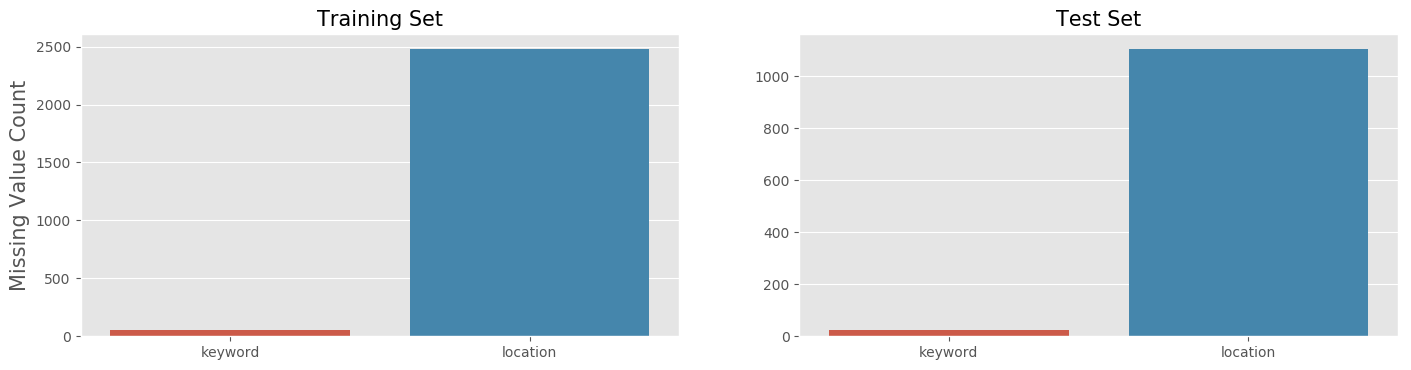

In [119]:
cols = ['keyword', 'location']
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=train_df[cols].isnull().sum().index, 
            y=train_df[cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=test_df[cols].isnull().sum().index, 
            y=test_df[cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count',size=15)
axes[0].set_title('Training Set', fontsize=15)
axes[1].set_title('Test Set', fontsize=15)

## 1-2) Target Distribution and Cardinality

Text(0, 0.5, 'Tweets')

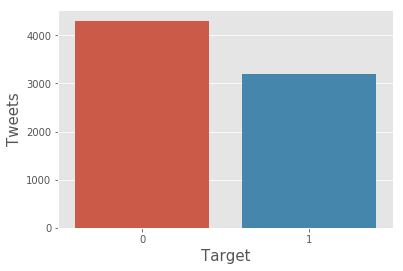

In [120]:
x = train_df.target.value_counts()
target_distribution = sns.barplot(x.index, x)
target_distribution.set_xlabel('Target', size=15)
target_distribution.set_ylabel('Tweets', size=15)

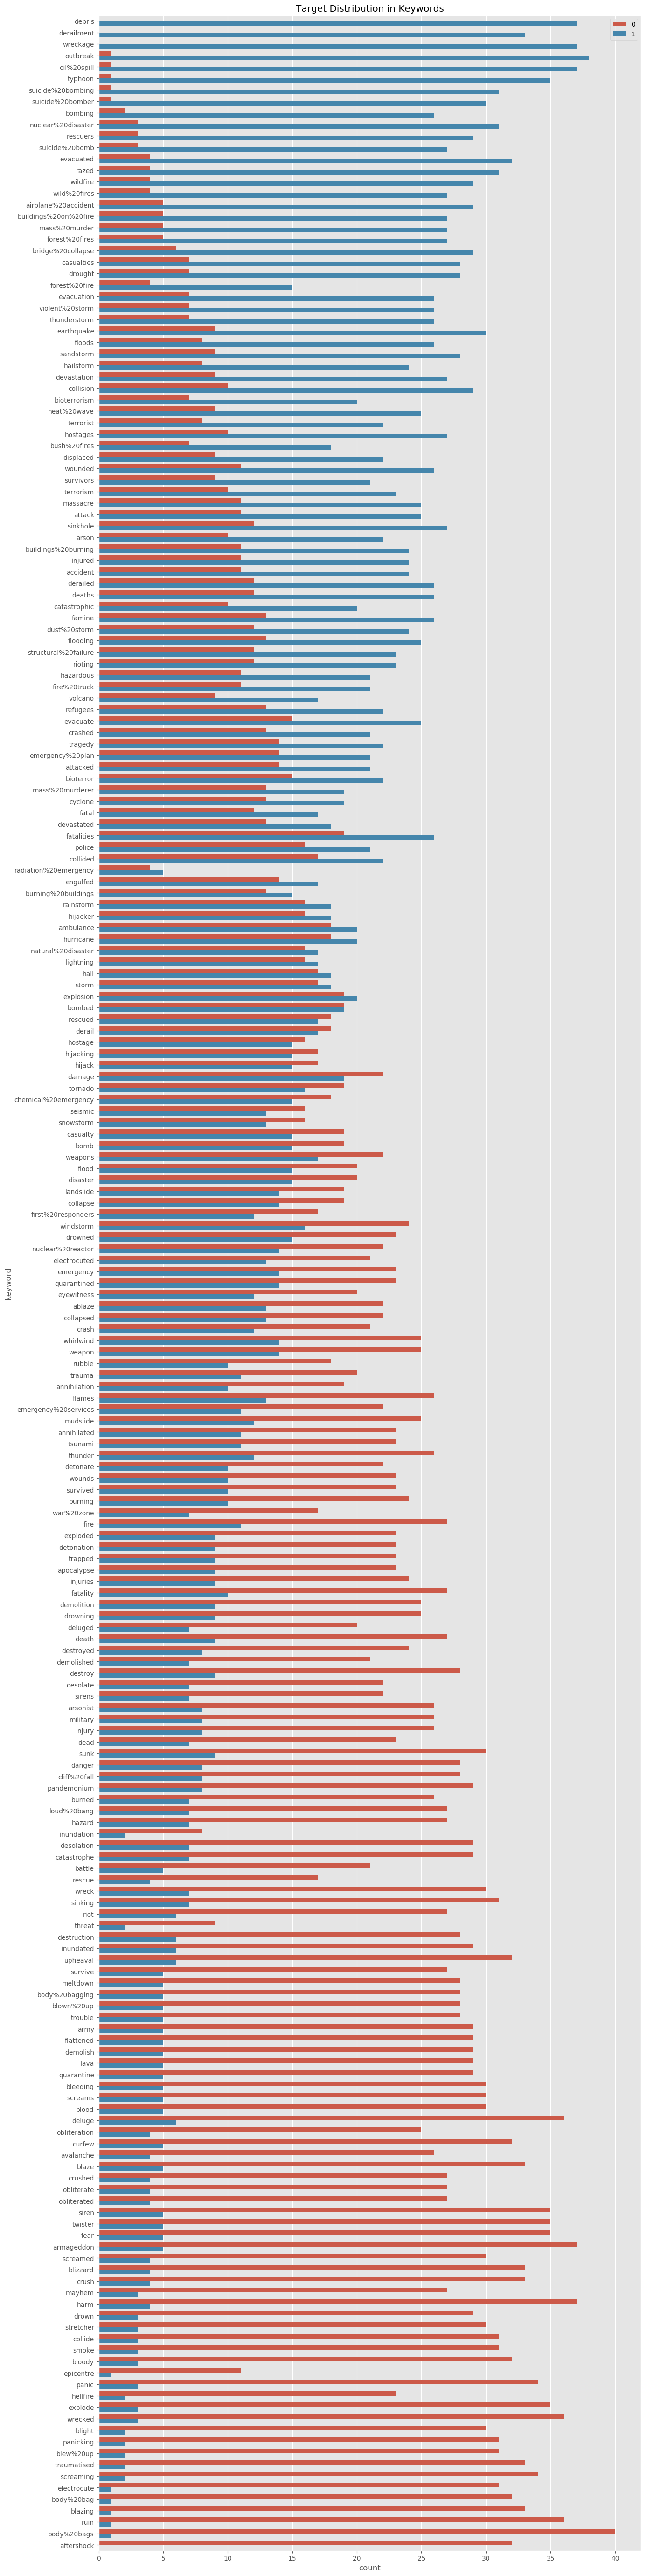

In [121]:
train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean')
fig = plt.figure(figsize=(15, 72), dpi=100)

sns.countplot(y=train_df.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_df.sort_values(by='target_mean', ascending=True)['target'])

#plt.tick_params(axis='x',labelsize=15)
#plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

## 1-3 ) Exploratory Data Analysis of Tweets

In [122]:
# number of characters
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['text'].apply(lambda x: len(str(x)))

# number of words
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# average word length of each tweet
train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# number of stop words
stop_words = set(stopwords.words('english')) 
train_df['stop_word_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

# number of hashtag
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# number of mention
train_df['mention_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

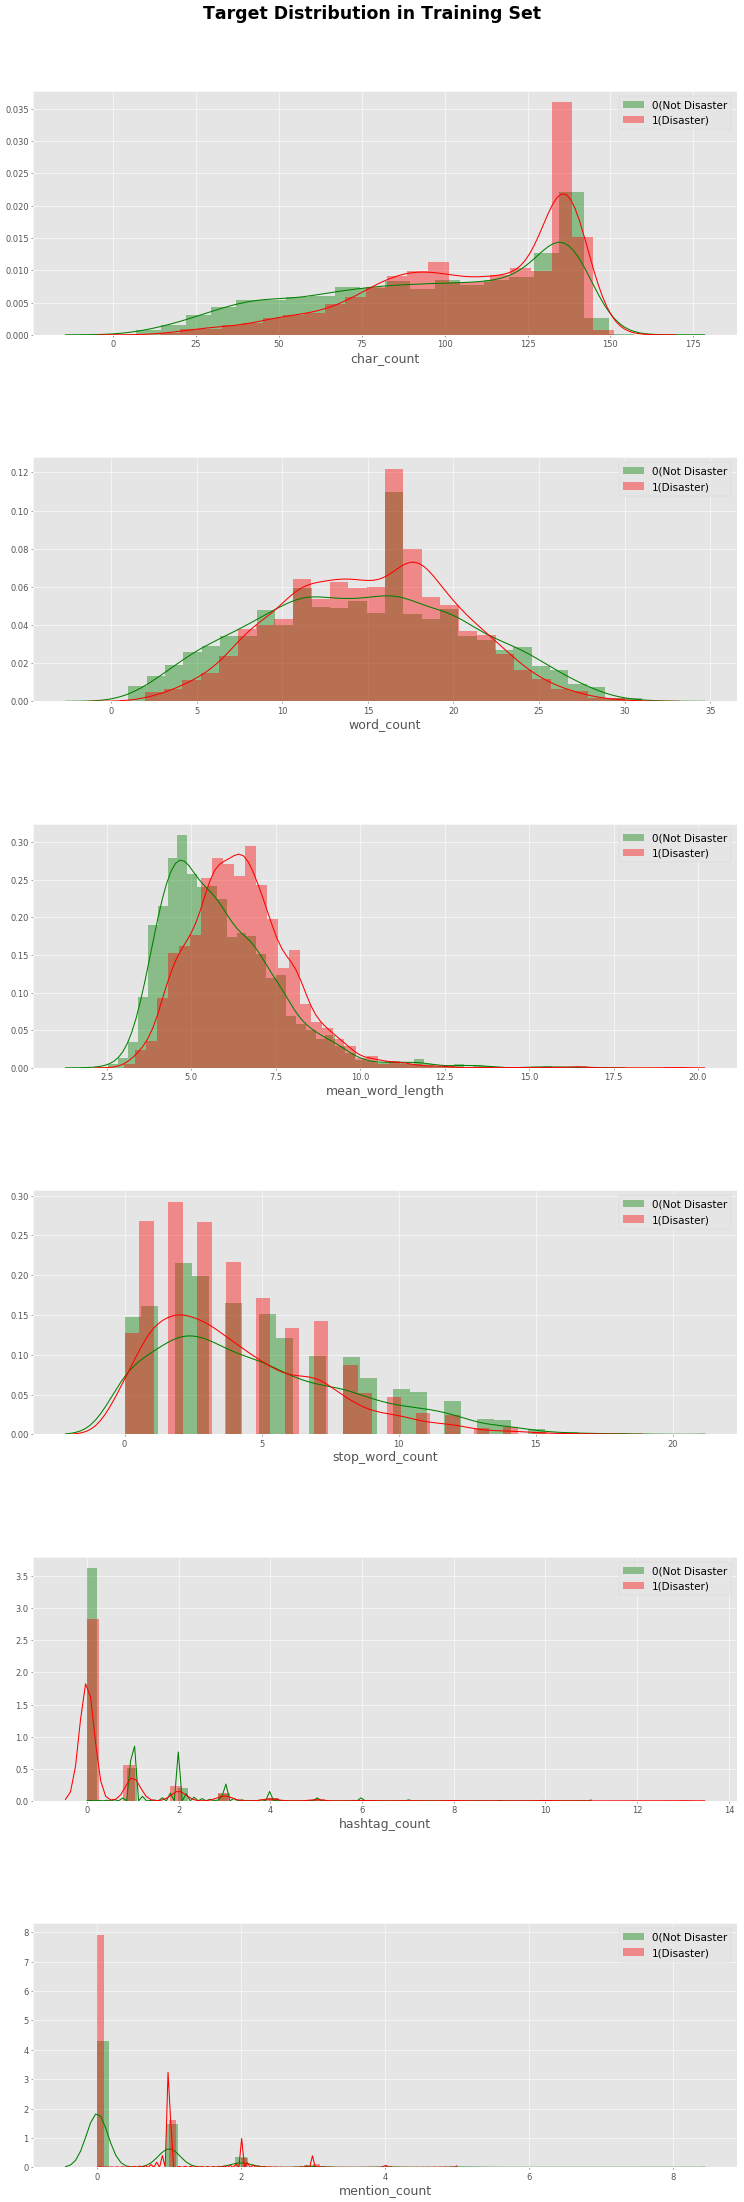

In [123]:
METAFEATURES = ['char_count', 'word_count', 'mean_word_length'
                , 'stop_word_count','hashtag_count', 'mention_count']
DISASTER_TWEETS = train_df['target'] == 1


fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(15, 50), dpi=50)


for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_df.loc[~DISASTER_TWEETS][feature], label='0(Not Disaster', ax=axes[i], color='green')
    sns.distplot(train_df.loc[DISASTER_TWEETS][feature], label='1(Disaster)', ax=axes[i], color='red')
    axes[i].legend(bbox_to_anchor=(0, 3))
    
    axes[i].set_xlabel(feature,fontsize=18)
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend(fontsize=15)
    
fig.suptitle('Target Distribution in Training Set',fontsize=25, fontweight='bold')   
fig.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.subplots_adjust(hspace = 0.5)
plt.show()

We can see that disaster tweets has  

1) more characters,  
2) longer average word length,  
3) less stop words  
4) and less mentions(@).

## 1-4) WordCloud

In [124]:
# disastaer vector

cv = feature_extraction.text.CountVectorizer(stop_words='english')
disaster_vec = cv.fit_transform(train_df.loc[DISASTER_TWEETS]['text'])
words = cv.get_feature_names()

count_mat = disaster_vec.sum(axis=0)
count = np.squeeze(np.asarray(count_mat))
count.shape
dis_word_count = list(zip(words,count))

dis_word_count = sorted(dis_word_count, key=lambda x:x[1],reverse=True)
dis_word_count[:10]

[('http', 2357),
 ('û_', 164),
 ('news', 140),
 ('amp', 134),
 ('https', 132),
 ('disaster', 116),
 ('california', 114),
 ('police', 108),
 ('suicide', 106),
 ('people', 102)]

In [125]:
# non-disastaer vector

cv = feature_extraction.text.CountVectorizer(stop_words='english')
non_dis_vec = cv.fit_transform(train_df.loc[~DISASTER_TWEETS]['text'])

words = cv.get_feature_names()
non_dis_count_mat = non_dis_vec.sum(axis=0)

non_dis_count = np.squeeze(np.asarray(non_dis_count_mat))

non_dis_word_count = list(zip(words,non_dis_count))  # transform to tuple (word,count)
non_dis_word_count = sorted(non_dis_word_count, key=lambda x:x[1],reverse=True)
non_dis_word_count[:10]

[('http', 1918),
 ('https', 276),
 ('like', 252),
 ('just', 234),
 ('amp', 208),
 ('û_', 174),
 ('new', 170),
 ('don', 135),
 ('body', 116),
 ('video', 95)]

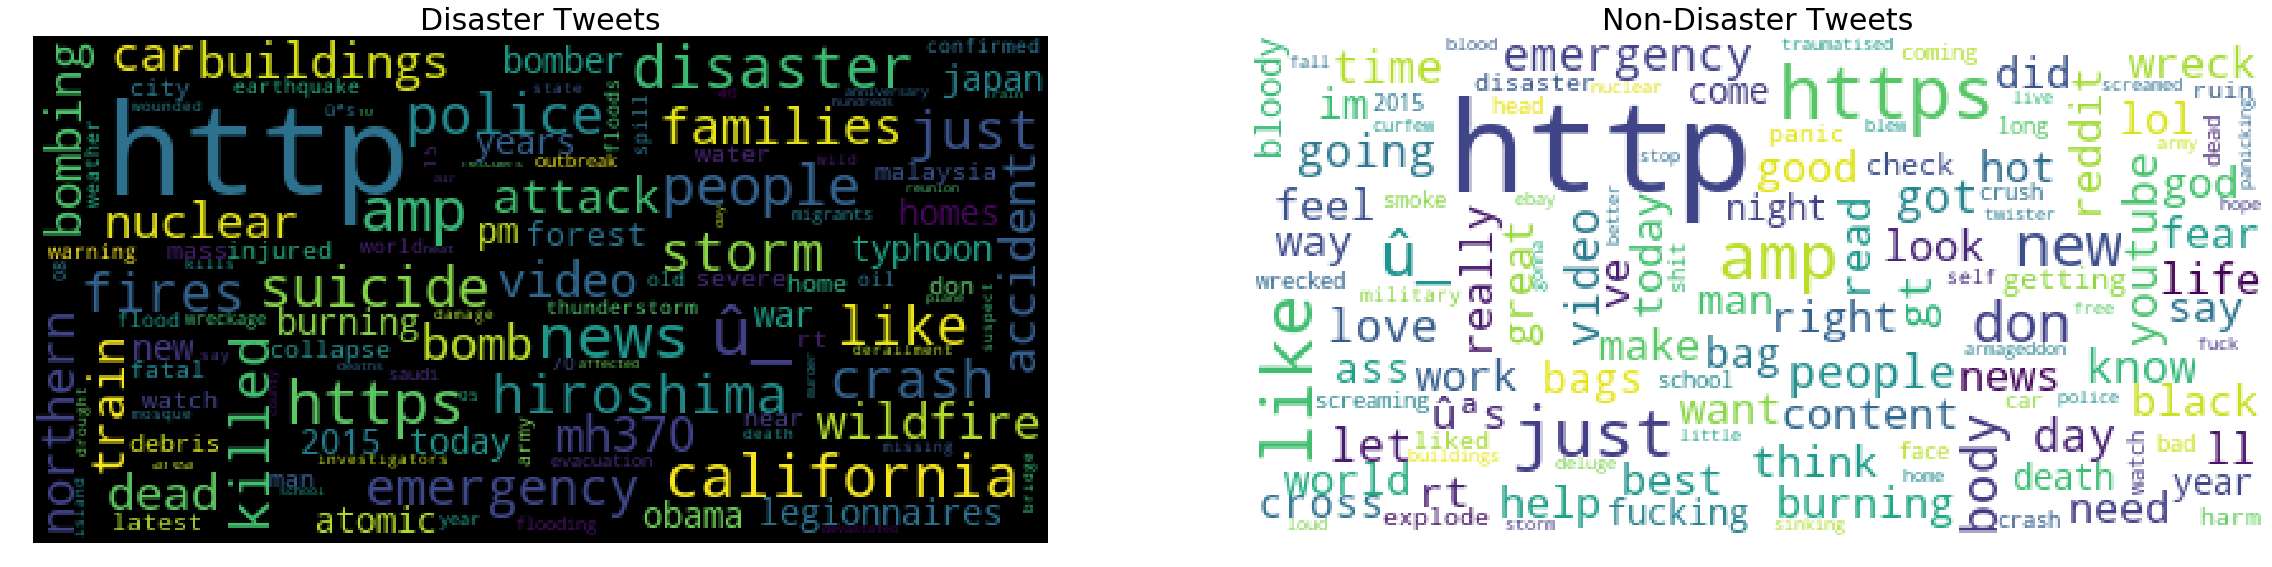

In [126]:
plt.figure(figsize=(40, 40))

plt.subplot(1,2,1).set_title("Disaster Tweets",fontsize=30)
dis_wc = WordCloud(max_font_size=50, max_words=120,background_color='Black')
dis_cloud = dis_wc.generate_from_frequencies(dict(dis_word_count))
plt.imshow(dis_cloud)
plt.axis('off')

plt.subplot(1,2,2).set_title("Non-Disaster Tweets",fontsize=30)
non_dis_wc = WordCloud(max_font_size=50, max_words=120,background_color='White')
non_dis_cloud = non_dis_wc.generate_from_frequencies(dict(non_dis_word_count))
plt.imshow(non_dis_cloud)
plt.axis('off')

plt.show()

It seems there are still useless words like 'http', 'https', or 'û_'.  
However we can see disaster tweets have more disaster related words like 'fires', 'killed', 'hiroshima' or 'nuclear'.

## 2) Preprocessing

## 2-1) Cleaning

Before modeling, we should clean text in both train and test data by removing punctuations, urls, emojis since they don't give much information about target.

In [127]:
concat_df = pd.concat([train_df,test_df])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [128]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')  # regular expression operations
    return url.sub(r'',text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)



In [129]:
!pip install pyspellchecker

In [130]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [131]:
cleaned_train_df = train_df
cleaned_train_df['text']=cleaned_train_df['text'].apply(lambda x : remove_URL(x))
cleaned_train_df['text']=cleaned_train_df['text'].apply(lambda x : remove_html(x))
cleaned_train_df['text']=cleaned_train_df['text'].apply(lambda x : remove_emoji(x))
cleaned_train_df['text']=cleaned_train_df['text'].apply(lambda x : remove_punct(x))
#cleaned_train_df['text']=cleaned_train_df['text'].apply(lambda x : correct_spellings(x))

cleaned_test_df = test_df
cleaned_test_df['text']=cleaned_test_df['text'].apply(lambda x : remove_URL(x))
cleaned_test_df['text']=cleaned_test_df['text'].apply(lambda x : remove_html(x))
cleaned_test_df['text']=cleaned_test_df['text'].apply(lambda x : remove_emoji(x))
cleaned_test_df['text']=cleaned_test_df['text'].apply(lambda x : remove_punct(x))
#cleaned_train_df['text']=cleaned_train_df['text'].apply(lambda x : correct_spellings(x))

(I tried to predict with the text after correcting the spelling, the leaderboard score decreased from 0.57523 to 0.55072.  
The result may differ depending on the model, but correcting spellings take too much time so I decided not to use it.)

In [132]:
test_df["text"].values[0:10]

array(['Just happened a terrible car crash',
       'Heard about earthquake is different cities stay safe everyone',
       'there is a forest fire at spot pond geese are fleeing across the street I cannot save them all',
       'Apocalypse lighting Spokane wildfires',
       'Typhoon Soudelor kills 28 in China and Taiwan',
       'Were shakingIts an earthquake',
       'Theyd probably still show more life than Arsenal did yesterday eh EH',
       'Hey How are you', 'What a nice hat', 'Fuck off'], dtype=object)

In [133]:
cleaned_train_df[cleaned_train_df["target"] == 1]["text"].values[0:20]

array(['Our Deeds are the Reason of this earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask Canada',
       'All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected',
       '13000 people receive wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school ',
       'RockyFire Update  California Hwy 20 closed in both directions due to Lake County fire  CAfire wildfires',
       'flood disaster Heavy rain causes flash flooding of streets in Manitou Colorado Springs areas',
       'Im on top of the hill and I can see a fire in the woods',
       'Theres an emergency evacuation happening now in the building across the street',
       'Im afraid that the tornado is coming to our area',
       'Three people died from the heat wave so far',
       'Haha South Tampa is getting flooded hah WAIT A SECOND I LIVE IN SOUT

In [134]:
cleaned_train_df[cleaned_train_df["target"] == 0]["text"].values[0:20]

array(['Whats up man', 'I love fruits', 'Summer is lovely',
       'My car is so fast', 'What a goooooooaaaaaal',
       'this is ridiculous', 'London is cool ', 'Love skiing',
       'What a wonderful day', 'LOOOOOOL', 'No wayI cant eat that shit',
       'Was in NYC last week', 'Love my girlfriend', 'Cooool ',
       'Do you like pasta', 'The end',
       'We always try to bring the heavy metal RT ',
       'Crying out for more Set me ablaze',
       'On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE ',
       'PhDSquares mufc theyve built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season'],
      dtype=object)

## 3) Modeling

## 3-1) CountVectorize

In [135]:
count_vectorizer = feature_extraction.text.CountVectorizer(stop_words='english')

train_vectors = count_vectorizer.fit_transform(train_df["text"])

# 학습데이터에서 설정된 변환을 위한 기반 설정을 그대로 테스트 데이터에 적용
# 학습할 때와 동일한 기반설정으로 동일하게 테스트 데이터를 변환
test_vectors = count_vectorizer.transform(test_df["text"])

In [136]:
# text : 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
train_vectors[0]

<1x17523 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Row format>

## 3-2) Recurrent Neural Network

In [137]:
X_data = cleaned_train_df['text']
y_data = cleaned_train_df['target']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data) # 5169개의 행을 가진 X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(X_data) # 단어를 숫자값, 인덱스로 변환하여 저장


X_test_data = cleaned_test_df['text']

tokenizer.fit_on_texts(X_test_data) # 5169개의 행을 가진 X의 각 행에 토큰화를 수행
sequences_test_data = tokenizer.texts_to_sequences(X_test_data)

In [138]:
print(sequences[:5])

[[107, 4429, 21, 1, 814, 5, 18, 245, 121, 1845, 4430, 66, 37], [175, 41, 222, 665, 6657, 6658, 1329], [37, 1669, 1541, 4, 2044, 3, 666, 21, 118, 6659, 17, 1670, 39, 395, 264, 53, 2044, 3, 666, 1330, 21, 1041], [2770, 58, 4431, 1331, 264, 1330, 3, 86], [28, 90, 1153, 18, 314, 19, 6660, 2045, 25, 250, 19, 1331, 6661, 65, 2, 176]]


In [139]:
word_to_index = tokenizer.word_index
print(word_to_index) # 각 단어의 빈도수가 높은 순서.

{'the': 1, 'a': 2, 'to': 3, 'in': 4, 'of': 5, 'and': 6, 'i': 7, 'is': 8, 'for': 9, 'on': 10, 'you': 11, 'my': 12, 'it': 13, 'with': 14, 'that': 15, 'by': 16, 'at': 17, 'this': 18, 'from': 19, 'are': 20, 'be': 21, 'was': 22, 'have': 23, 'like': 24, 'as': 25, 'just': 26, 'up': 27, 'me': 28, 'amp': 29, 'but': 30, 'so': 31, 'not': 32, 'your': 33, 'im': 34, 'out': 35, 'no': 36, 'will': 37, 'all': 38, 'its': 39, 'after': 40, 'fire': 41, 'we': 42, 'an': 43, 'when': 44, 'if': 45, 'get': 46, 'has': 47, 'new': 48, 'more': 49, 'via': 50, 'about': 51, 'now': 52, 'how': 53, 'or': 54, 'he': 55, 'news': 56, 'what': 57, 'one': 58, 'people': 59, 'they': 60, 'dont': 61, 'who': 62, 'over': 63, 'do': 64, 'us': 65, 'been': 66, 'into': 67, '2': 68, 'can': 69, 'were': 70, 'emergency': 71, 'video': 72, 'there': 73, 'disaster': 74, 'would': 75, 'police': 76, 'her': 77, 'his': 78, 'than': 79, 'still': 80, 'some': 81, 'why': 82, 'body': 83, 'crash': 84, 'off': 85, 'suicide': 86, 'first': 87, 'storm': 88, 'them':

In [140]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 14360
단어 집합(vocabulary)에서 희귀 단어의 비율: 62.95760445438204
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.51434439806533


In [141]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 22810


메일의 최대 길이 : 31
메일의 평균 길이 : 13.990271


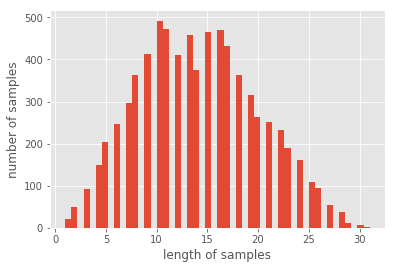

In [142]:
X_data = sequences # 단어를 정수 인코딩한 결과
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [143]:
max_len = 31
# 전체 데이터셋의 길이는 max_len으로 맞춥니다.
data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", data.shape)

훈련 데이터의 크기(shape):  (7503, 31)


Let's create a model using RNN.

In [144]:
X_train = data
y_train = np.array(y_data)

model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          729920    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 732,033
Trainable params: 732,033
Non-trainable params: 0
_________________________________________________________________


In [145]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=4, batch_size=16, validation_split=0.2)

Train on 6002 samples, validate on 1501 samples
Epoch 1/4
6002/6002 [==============================] - 6s 1ms/sample - loss: 0.5813 - acc: 0.6979 - val_loss: 0.5437 - val_acc: 0.7455
Epoch 2/4
6002/6002 [==============================] - 5s 804us/sample - loss: 0.3692 - acc: 0.8496 - val_loss: 0.5402 - val_acc: 0.7308
Epoch 3/4
6002/6002 [==============================] - 4s 748us/sample - loss: 0.2336 - acc: 0.9162 - val_loss: 0.6114 - val_acc: 0.7062
Epoch 4/4
6002/6002 [==============================] - 5s 780us/sample - loss: 0.1487 - acc: 0.9557 - val_loss: 0.7502 - val_acc: 0.6696


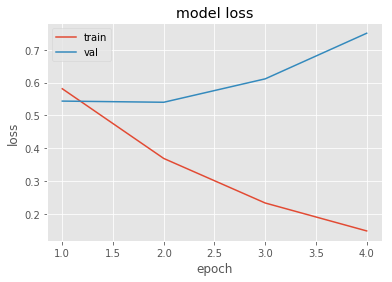

In [146]:
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### submission 1 :
* epochs = 2,  
* batch_size = 32,  
* validation_split=0.2  

#### score = 0.59975

#### submission 2 :

#### submission 3 :

## 3-3) Multi Layer Perceptron(MLP) Artificial Neural Network 

In [167]:
MLPmodel = Sequential()
MLPmodel.add(Embedding(vocab_size, 128, input_length=max_len))
MLPmodel.add(Flatten())
MLPmodel.add(Dense(256, activation='relu'))
MLPmodel.add(Dense(1, activation='sigmoid'))

MLPmodel.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 31, 128)           2919680   
_________________________________________________________________
flatten_4 (Flatten)          (None, 3968)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               1016064   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 3,936,001
Trainable params: 3,936,001
Non-trainable params: 0
_________________________________________________________________


In [172]:
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
#history = model.fit(X_train, y_train, epochs=4, batch_size=16, validation_split=0.2)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model.fit(X_train, y_train, epochs=4, batch_size=64, validation_split=0.2)

Train on 6002 samples, validate on 1501 samples
Epoch 1/4
6002/6002 [==============================] - 3s 429us/sample - loss: 0.6799 - accuracy: 0.5821 - val_loss: 0.6939 - val_accuracy: 0.5403
Epoch 2/4
6002/6002 [==============================] - 1s 150us/sample - loss: 0.6797 - accuracy: 0.5821 - val_loss: 0.6929 - val_accuracy: 0.5403
Epoch 3/4
6002/6002 [==============================] - 1s 149us/sample - loss: 0.6799 - accuracy: 0.5821 - val_loss: 0.6938 - val_accuracy: 0.5403
Epoch 4/4
6002/6002 [==============================] - 1s 147us/sample - loss: 0.6799 - accuracy: 0.5821 - val_loss: 0.6934 - val_accuracy: 0.5403


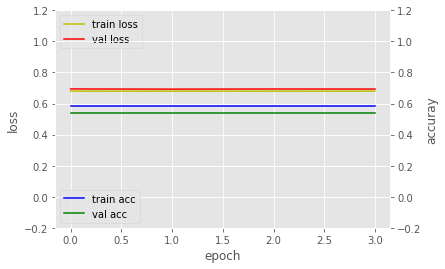

In [174]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [175]:
loss_and_metrics = MLPmodel.evaluate(X_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

NameError: name 'X_test' is not defined

## 3-4) Convolution Neural Network

## 3-5) Recurrent Convolution Neural Network(RCNN)

## 4) Make submission

In [162]:
X_test_data =sequences_test_data # 단어를 정수 인코딩한 결과
print('test 메일의 최대 길이 : %d' % max(len(l) for l in X_test_data))  #max_len
test_pad = pad_sequences(X_test_data, maxlen = max_len) #max_len

test 메일의 최대 길이 : 31


In [148]:
# practice
#sequences_test_data.shape()
print(test_pad.shape)

(3263, 31)


In [149]:
#sample_sub_2=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [150]:
y_pre=model.predict(test_pad)
y_pre=np.round(y_pre).astype(int).reshape(test_df.shape[0])
sub=pd.DataFrame({'id':sample_sub_2['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission_3.csv',index=False)

In [151]:
sub.tail()

,id,target
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,0
3262,10875,0


Let's start from assuming that count-vector and target value(0 or 1) have linear connection. For testing on the trining data, I'll use cross-validation and the metric will be F1 score, which this competition is asking for.

In [152]:
ln_clf = linear_model.RidgeClassifier()

scores = model_selection.cross_val_score(ln_clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.59777424, 0.50442939, 0.60040161])

+) TFIDF, LSA, LSTM, RNNs, ngram ,...

In [153]:
ln_clf.fit(train_vectors, train_df['target'])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [154]:
count_vectorizer2 = feature_extraction.text.CountVectorizer(stop_words = 'english')
count_vectorizer2.fit_transform(train_df['text'])
test_vectors = count_vectorizer.transform(test_df["text"])

In [155]:
#count_vectorizer2.vocabulary_

{'deeds': 4442,
 'reason': 12685,
 'earthquake': 5214,
 'allah': 1142,
 'forgive': 6311,
 'forest': 6301,
 'near': 10680,
 'la': 8947,
 'ronge': 13240,
 'sask': 13527,
 'canada': 2912,
 'residents': 12956,
 'asked': 1576,
 'shelter': 13915,
 'place': 11868,
 'notified': 10943,
 'officers': 11107,
 'evacuation': 5645,
 'orders': 11298,
 'expected': 5734,
 '13000': 140,
 'people': 11668,
 'receive': 12705,
 'wildfires': 16950,
 'california': 2866,
 'just': 8597,
 'got': 6854,
 'sent': 13774,
 'photo': 11764,
 'ruby': 13333,
 'alaska': 1091,
 'smoke': 14262,
 'pours': 12060,
 'school': 13607,
 'rockyfire': 13195,
 'update': 16290,
 'hwy': 7731,
 '20': 258,
 'closed': 3487,
 'directions': 4749,
 'lake': 8970,
 'county': 3935,
 'cafire': 2835,
 'flood': 6198,
 'disaster': 4771,
 'heavy': 7312,
 'rain': 12544,
 'causes': 3083,
 'flash': 6162,
 'flooding': 6200,
 'streets': 14819,
 'manitou': 9703,
 'colorado': 3621,
 'springs': 14570,
 'areas': 1456,
 'im': 7877,
 'hill': 7432,
 'woods': 170

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer
train_tfidf_vec = TfidfVectorizer().fit_transform(train_df['text'])
test_tfidf_vec = TfidfVectorizer().fit(test_df['text'])

In [157]:
train_tfidf_vec

<7503x17798 sparse matrix of type '<class 'numpy.float64'>'
	with 96059 stored elements in Compressed Sparse Row format>

## submission example

In [158]:
#mysample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [159]:
mysample_submission["target"] = ln_clf.predict(test_vectors)

mysample_submission.head()

NameError: name 'mysample_submission' is not defined

In [ ]:
mysample_submission.to_csv("mysubmission.csv", index=False)